In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
pd.set_option('display.max_columns', 50)

import gensim
from gensim import models
import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

import nltk, string,re
from nltk.corpus import stopwords
from textblob import TextBlob
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import LdaMulticore

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

In [5]:
#Downgraded my numpy version to reduce the errors from LDAMulticore.
np.version.version

'1.13.3'

In [12]:
#Loading the pickled car dataframe
with open('car_df_cleaned', 'rb') as f:
    car_df = pickle.load(f)

# Topic Modeling with NMF with sklearn

In [13]:
#Vectorizing the pre-processed documents using Count Vec and TF-IDF Vect
vectorizer = TfidfVectorizer()
cv = CountVectorizer()

In [14]:
#Using Countvect
t0 = time()
count = cv.fit_transform(car_df.review).toarray()
print("done in %0.3fs." % (time() - t0))

done in 5.295s.


In [15]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(car_df['review'])
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 1.994s.


In [16]:
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = tfidf_vectorizer.get_feature_names())

In [17]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features")
t0 = time()
model = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5)
nmf = model.fit_transform(tfidf)
print("done in %0.3fs." % (time() - t0))

Fitting the NMF model with tf-idf features
done in 4.486s.


In [18]:
W = nmf
H = model.components_

The W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.


The H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.



In [19]:
# Helper functions for grabbing the topics
def get_descriptor(terms, H, topic_index, top):
    #reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:])[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms
    
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def get_top_cars(df,W,topic_index,number):
    #getting reversed order of cars
    top_indices = np.argsort(W[:,topic_index])[::-1]
    
    top_cars = []
    for caridx in top_indices[0:number]:
        top_cars.append(df.iloc[caridx])
    return top_cars

In [20]:
print_top_words(model,tfidf_vectorizer.get_feature_names(),5)

Topic #0:
like drive feel better good
Topic #1:
problem dealer issue time transmission
Topic #2:
truck tacoma tundra chevy trailer
Topic #3:
seat back front rear room
Topic #4:
mile highway trip mileage tire
Topic #5:
vehicle owned jeep purchased purchase
Topic #6:
love drive absolutely still everything
Topic #7:
great ride mileage good comfortable
Topic #8:
honda accord toyota civic pilot
Topic #9:
ford focus escape fusion transmission



In [21]:
get_top_cars(car_df,W,0,5)

[vehicle        2016 Honda Civic Sedan LX 4dr Sedan (2.0L 4cyl...
 review         reviewer think getting lexus quality going hap...
 rating                                                         5
 text_length                                                   87
 Name: 10187, dtype: object,
 vehicle        2015 BMW 2 Series Coupe 228i SULEV 2dr Coupe (...
 review         update issue still enjoying still could change...
 rating                                                         4
 text_length                                                  362
 Name: 3665, dtype: object,
 vehicle        2017 Hyundai Elantra Sedan SE PZEV w/Prod. End...
 review         first thing trim amazingly well equipped insid...
 rating                                                         5
 text_length                                                  222
 Name: 13803, dtype: object,
 vehicle        2016 Subaru WRX Sedan 4dr Sedan AWD (2.0L 4cyl...
 review         loving completely different interior eng

# LDA with Genism

In [22]:
#Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.
processed_docs = car_df.review.str.split()
dictionary = gensim.corpora.Dictionary(processed_docs)

In [23]:
#For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [15]:
#Creating a new TFIDF dictionary formatted for Gensim.
tfidf_lda = models.TfidfModel(bow_corpus)
corpus_tfid = tfidf_lda[bow_corpus]

In [9]:
print("LDA model with tf-idf features")
t0 = time()

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8,id2word=dictionary,chunksize=100, workers=8,passes=20,minimum_probability=0.0,iterations=20);

print("done in %0.3fs." % (time() - t0))

LDA model with tf-idf features


NameError: name 'bow_corpus' is not defined

In [63]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.056*"seat" + 0.021*"back" + 0.018*"rear" + 0.016*"front" + 0.011*"driver" + 0.010*"door" + 0.010*"space" + 0.010*"like" + 0.009*"passenger" + 0.009*"room"
Topic: 1 Word: 0.017*"vehicle" + 0.012*"price" + 0.010*"year" + 0.009*"model" + 0.009*"lexus" + 0.009*"drive" + 0.008*"test" + 0.008*"feature" + 0.007*"better" + 0.007*"best"
Topic: 2 Word: 0.018*"problem" + 0.017*"issue" + 0.017*"dealer" + 0.014*"time" + 0.011*"mile" + 0.011*"vehicle" + 0.010*"dealership" + 0.009*"transmission" + 0.009*"back" + 0.009*"service"
Topic: 3 Word: 0.023*"system" + 0.015*"control" + 0.011*"feature" + 0.010*"work" + 0.009*"radio" + 0.009*"phone" + 0.009*"navigation" + 0.008*"screen" + 0.008*"like" + 0.007*"time"
Topic: 4 Word: 0.039*"great" + 0.020*"good" + 0.020*"ride" + 0.019*"drive" + 0.019*"love" + 0.017*"comfortable" + 0.015*"like" + 0.013*"well" + 0.012*"mileage" + 0.011*"driving"
Topic: 5 Word: 0.038*"truck" + 0.025*"ford" + 0.013*"year" + 0.013*"bought" + 0.012*"like" + 0.012*"chevy

In [67]:
#Computing Perplexity
perplexity_score = lda_model.log_perplexity(bow_corpus);

In [64]:
#Computing Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts= processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda_score = coherence_model_lda.get_coherence()

In [66]:
#For a topics of 10.
print('Coherence_score', coherence_lda_score)
print('Perplexity_score', perplexity_score)

Coherence_score 0.438109531212
Perplexity_score -7.58722182877


### Number of topics tuning using coherence scores


The coherence score is for assessing the quality of the learned topics.

Topic coherence looks at a set of words in generated topics and rates the interpretability of the topics. There are a number of measures that calculate coherence in various ways, but Cv proves to be the measure most aligned with human interpretability 

In [69]:
def compute_coherence_values(dictionary, corpus, texts, limit, start =1, step =2):
    coherence_values =[]
    model_list =[]
    for num_topics in range(start,limit,step):
        model  = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics,id2word=dictionary,chunksize=100, workers=8,passes=20,minimum_probability=0.0,iterations=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary = dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [70]:
model_list , coherence_values = compute_coherence_values(dictionary, bow_corpus, processed_docs,30,start=1,step=2)

In [71]:
coherence_values

[0.28939784922219153,
 0.380189811752006,
 0.39119613854624125,
 0.42257020387645255,
 0.42230448041588975,
 0.45739784983001947,
 0.42988928841734142,
 0.46606103792394576,
 0.44462730514681215,
 0.44906733872955873,
 0.43811130924379132,
 0.470044261181846,
 0.46021154085554178,
 0.46373419823638395,
 0.4208487793641657]

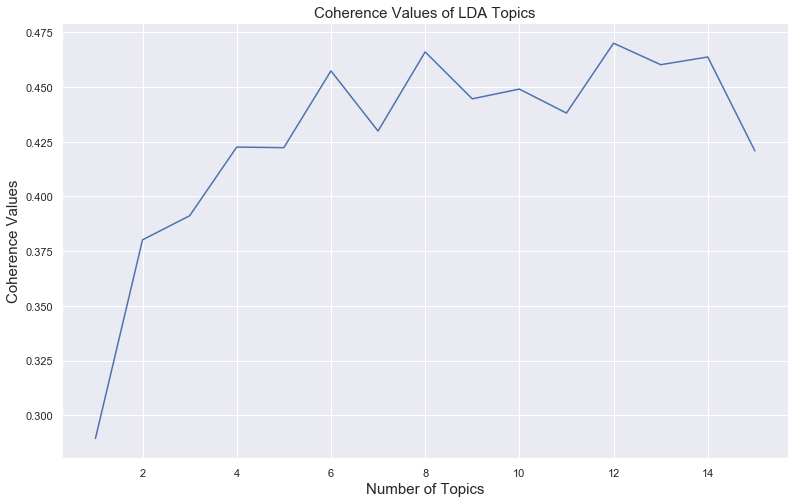

In [174]:
plt.figure(figsize=(13,8))
plt.plot(np.arange(1,16,1),coherence_values)
plt.xlabel('Number of Topics',fontsize=15)
plt.ylabel('Coherence Values',fontsize=15)
plt.title('Coherence Values of LDA Topics',fontsize=15)
plt.savefig("coherencescores1.svg")

After tuning the various parameters (passes and chuck sizes) in the LDA Model, the Coherence Scores for the the # of Topics were plotted. The number of topic clusters that were extracted from the LDA Model was 8.

### pyLDA Visualization

In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.129634  0.183688       1        1  17.671404
4      0.047925 -0.163516       2        1  15.539996
1     -0.067679 -0.142742       3        1  14.461552
3      0.135103  0.167361       4        1  11.795284
0      0.208367  0.019058       5        1  11.386728
6     -0.113340  0.029138       6        1  10.612321
7      0.092804 -0.065437       7        1   9.337083
5     -0.173546 -0.027550       8        1   9.195630, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
22    Default  18997.000000          seat  18997.000000  30.0000  30.0000
74    Default  22852.000000          mile  22852.000000  29.0000  29.0000
1310  Default   9000.000000         truck   9000.000000  28.0000  28.0000
48    Default  21878.000000         great  21878.000000  27.0000  27.0000
657   Default   6901.000000          ford   6901.000000  26.0000  26.0000
231   Default   9198.000000        system   9198.000000  25.0000  25.0000
413   Default   9218.000000  transmission   9218.000000  24.0000  24.0000
59    Default  10975.000000          ride  10975.000000  23.0000  23.0000
126   Default   6830.000000          tire   6830.000000  22.0000  22.0000
259   Default   7109.000000          rear   7109.000000  21.0000  21.0000
12    Default  12760.000000          love  12760.000000  20.0000  20.0000
147   Default   9371.000000   comfortable   9371.000000  19.0000  19.0000
463   Default   9849.000000        dealer   9849.000000  18.0000  18.0000
3     Default  14472.000000          back  14472.000000  17.0000  17.0000
187   Default   9576.000000       mileage   9576.000000  16.0000  16.0000
202   Default  12040.000000       problem  12040.000000  15.0000  15.0000
91    Default   6703.000000         front   6703.000000  14.0000  14.0000
79    Default   6395.000000          trip   6395.000000  13.0000  13.0000
618   Default   6634.000000         speed   6634.000000  12.0000  12.0000
380   Default  11830.000000        engine  11830.000000  11.0000  11.0000
179   Default  11246.000000         issue  11246.000000  10.0000  10.0000
496   Default   7839.000000       feature   7839.000000   9.0000   9.0000
25    Default   5026.000000         sport   5026.000000   8.0000   8.0000
134   Default  14882.000000          year  14882.000000   7.0000   7.0000
149   Default   6431.000000       control   6431.000000   6.0000   6.0000
8     Default   7493.000000       highway   7493.000000   5.0000   5.0000
177   Default   9468.000000      interior   9468.000000   4.0000   4.0000
637   Default   3208.000000         chevy   3208.000000   3.0000   3.0000
78    Default   4500.000000          room   4500.000000   2.0000   2.0000
2581  Default   3331.000000         lexus   3331.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
420    Topic8    947.680725      chrysler   1626.462158   1.8463  -5.5295
400    Topic8   1839.708496        toyota   4086.802979   1.5883  -4.8662
1102   Topic8    561.107849         focus    927.906006   1.8834  -6.0536
2988   Topic8    533.457153     chevrolet    871.848145   1.8952  -6.1042
4      Topic8   3003.389893        bought   9343.349609   1.2515  -4.3760
389    Topic8   1696.972168        nissan   4485.588867   1.4144  -4.9469
381    Topic8   1563.124390          ever   4357.488770   1.3612  -5.0291
286    Topic8    852.769043         loved   1815.194458   1.6310  -5.6350
107    Topic8   1839.852661         never   6354.507812   1.1470  -4.8661
134    Topic8   3037.865723          year  14882.519531   0.7974  -4.3646
2598   Topic8    512.010620         grand    868.221619   1.8583  -6.1452
15     Topic8   1771.972900         owned   6980.138672   1.0155  -4.9037
12     Topic8   2523.171631          love  12760.398438   0.7656  -4.5503
715    Topic8

### Mapping LDA results (topic distributions and topic keywords) back to the original car reviews

In [25]:
def format_topics_sentences(lda_model,corpus):
    '''Mapping dominant topic, probability of the topic occuring, and the keywords of the original 
    review documents onto a new dataframe'''
    
    '''Returning a list that can be used to make a dataframe'''
    
    topic_list = []
    
    for i,row in enumerate(lda_model[corpus]):     
        row = sorted(row, key = lambda x:x[1],reverse=True)  
        
        for j,(topic_num,prop_topic) in enumerate(row):
            
            if j== 0 :              
                words = lda_model.show_topic(topic_num)            
                topic_keywords = ','.join([word for word,prob in words])             
                topic_list.append([int(topic_num),round(prop_topic,4),topic_keywords])               
    return topic_list

In [26]:
tmplist = format_topics_sentences(lda_model,bow_corpus)

In [27]:
document_df = pd.DataFrame(tmplist,columns=['topic_num','topicprob', 'keywords'])

In [28]:
new_car_df = pd.concat([car_df,document_df],axis=1)

### Mapping the most representative documents for each topic

In [36]:
def get_top_cars(new_car_df,topicnum,num_cars):
    return new_car_df[new_car_df.topic_num == topicnum].sort_values(['topicprob'],ascending=False)[:num_cars]

def get_top_cars_filter(new_car_df,topicnum,num_cars,carfilter):
    return new_car_df[(new_car_df.topic_num == topicnum) & (new_car_df.type == carfilter)].sort_values(['topicprob'],ascending=False)[:num_cars]

In [37]:
new_car_df.head()

,vehicle,review,rating,text_length,topic_num,topicprob,keywords
0,2011 Volkswagen Eos Convertible Lux SULEV 2dr ...,bought used love decade owned mercedes reminis...,5.0,31,4,0.5476,"great,good,ride,drive,love,comfortable,like,we..."
1,2014 Volkswagen Eos Convertible Executive 2dr ...,beautiful understated done lack character hold...,4.0,40,7,0.3024,"transmission,speed,engine,like,sport,gear,feel..."
2,2014 Volkswagen Eos Convertible Executive 2dr ...,purchased executive loving worried head room p...,4.0,17,4,0.8095,"great,good,ride,drive,love,comfortable,like,we..."
3,2012 Volkswagen Eos Convertible Lux SULEV 2dr ...,sport period wife life style michlelins hold t...,5.0,72,7,0.3627,"transmission,speed,engine,like,sport,gear,feel..."
4,2012 Volkswagen Eos Convertible Lux SULEV 2dr ...,bought november looking sharp convertible fron...,4.0,160,0,0.3071,"seat,back,rear,front,driver,door,space,like,pa..."


In [38]:
get_top_cars(new_car_df,7,10)

,vehicle,review,rating,text_length,topic_num,topicprob,keywords
3938,2013 BMW 1 Series Convertible 135i 2dr Convert...,second convertible time review somewhat reluct...,4.0,50,7,0.9828,"transmission,speed,engine,like,sport,gear,feel..."
13104,2017 Hyundai Sonata Sedan Eco 4dr Sedan (1.6L ...,adding title know suspension different sport s...,2.0,23,7,0.9635,"transmission,speed,engine,like,sport,gear,feel..."
124,2011 Volkswagen CC Sedan Sport 4dr Sedan (2.0L...,good value transmission wrong shift point driv...,4.0,34,7,0.9368,"transmission,speed,engine,like,sport,gear,feel..."
24157,2017 FIAT 124 Spider Convertible Classica 2dr ...,drop dead gorgeous immediately styling handlin...,5.0,12,7,0.9326,"transmission,speed,engine,like,sport,gear,feel..."
25448,2016 Acura MDX SUV SH-AWD w/AcuraWatch Plus Pa...,rough shifting idle first second jerky shiftin...,3.0,12,7,0.9325,"transmission,speed,engine,like,sport,gear,feel..."
37217,2015 Dodge Challenger R/T Scat Pack R/T Scat P...,massive amount torque manual transmission mean...,5.0,11,7,0.9270,"transmission,speed,engine,like,sport,gear,feel..."
4001,2011 BMW 7 Series Sedan 740Li 4dr Sedan (3.0L ...,efficient dynamic twin turbo inline awesome ba...,5.0,10,7,0.9204,"transmission,speed,engine,like,sport,gear,feel..."
6598,2014 Porsche Boxster Convertible 2dr Convertib...,quick packing serious factor boxster equipped ...,5.0,9,7,0.9124,"transmission,speed,engine,like,sport,gear,feel..."
11838,2017 MINI Hardtop 2 Door John Cooper Works Joh...,take demo test hang tight sport mode performan...,5.0,13,7,0.9034,"transmission,speed,engine,like,sport,gear,feel..."
34916,2015 Nissan Altima Sedan 2.5 S 4dr Sedan (2.5L...,differetn previous type transmission expect us...,5.0,8,7,0.9027,"transmission,speed,engine,like,sport,gear,feel..."


## Mapping all the topic distributions back to the original dataframe

In [39]:
topics = [lda_model[bow_corpus[i]] for i in range(len(car_df))]

In [40]:
def topic_prob_df(topics,num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics:
        res.loc[0,topic_weight[0]] = topic_weight[1]
    return res

In [41]:
topic_prob_df = pd.concat([topic_prob_df(topics_document, num_topics=8) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [42]:
topic_prob_df.head()

,0,1,2,3,4,5,6,7
0,0.003924,0.149058,0.075317,0.003913,0.548045,0.003913,0.003912,0.211918
1,0.003054,0.112374,0.003053,0.286241,0.284854,0.003054,0.003052,0.304318
2,0.006952,0.007019,0.006961,0.006946,0.808170,0.006953,0.150037,0.006960
3,0.355180,0.001715,0.070728,0.001715,0.001715,0.041462,0.163596,0.363889
4,0.307219,0.127407,0.117600,0.127863,0.275972,0.000778,0.042383,0.000778


In [43]:
topic_prob_df.rename(columns={0:'topic_1',1:'topic_2',2:'topic_3',3:'topic_4',4:'topic_5',5:'topic_6',
                              6:'topic_7',7:'topic_8'},inplace=True)

In [44]:
#Adding topic_prob dataframe to main dataframe
car_df_final = pd.concat([new_car_df,topic_prob_df],axis=1)

In [45]:
car_df_final

,vehicle,review,rating,text_length,topic_num,topicprob,keywords,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,2011 Volkswagen Eos Convertible Lux SULEV 2dr ...,bought used love decade owned mercedes reminis...,5.0,31,4,0.5476,"great,good,ride,drive,love,comfortable,like,we...",0.003924,0.149058,0.075317,0.003913,0.548045,0.003913,0.003912,0.211918
1,2014 Volkswagen Eos Convertible Executive 2dr ...,beautiful understated done lack character hold...,4.0,40,7,0.3024,"transmission,speed,engine,like,sport,gear,feel...",0.003054,0.112374,0.003053,0.286241,0.284854,0.003054,0.003052,0.304318
2,2014 Volkswagen Eos Convertible Executive 2dr ...,purchased executive loving worried head room p...,4.0,17,4,0.8095,"great,good,ride,drive,love,comfortable,like,we...",0.006952,0.007019,0.006961,0.006946,0.808170,0.006953,0.150037,0.006960
3,2012 Volkswagen Eos Convertible Lux SULEV 2dr ...,sport period wife life style michlelins hold t...,5.0,72,7,0.3627,"transmission,speed,engine,like,sport,gear,feel...",0.355180,0.001715,0.070728,0.001715,0.001715,0.041462,0.163596,0.363889
4,2012 Volkswagen Eos Convertible Lux SULEV 2dr ...,bought november looking sharp convertible fron...,4.0,160,0,0.3071,"seat,back,rear,front,driver,door,space,like,pa...",0.307219,0.127407,0.117600,0.127863,0.275972,0.000778,0.042383,0.000778
5,2012 Volkswagen Eos Convertible Komfort SULEV ...,enough much love handling tight ride comfortab...,5.0,24,4,0.5053,"great,good,ride,drive,love,comfortable,like,we...",0.005005,0.005005,0.005001,0.005005,0.505255,0.005003,0.005003,0.464723
6,2012 Volkswagen Eos Convertible Komfort SULEV ...,love everything except rear seat passenger wou...,5.0,11,0,0.9268,"seat,back,rear,front,driver,door,space,like,pa...",0.757339,0.010427,0.010423,0.010425,0.010443,0.180098,0.010422,0.010422
7,2012 Volkswagen Eos Convertible Komfort SULEV ...,bought wanted hardtop convertible loved look i...,2.0,88,2,0.5653,"problem,issue,dealer,time,mile,vehicle,dealers...",0.001406,0.331471,0.565091,0.017524,0.001407,0.001407,0.001446,0.080248
8,2012 Volkswagen Eos Convertible Komfort SULEV ...,great look super convertible lowering raising ...,5.0,52,4,0.4930,"great,good,ride,drive,love,comfortable,like,we...",0.309543,0.002360,0.002362,0.002361,0.493002,0.002362,0.185647,0.002362
9,2012 Volkswagen Eos Convertible Lux SULEV 2dr ...,love beautiful coupe styling quick disappearin...,5.0,58,4,0.3361,"great,good,ride,drive,love,comfortable,like,we...",0.233280,0.092516,0.040654,0.168638,0.334973,0.028933,0.002122,0.098884


## LDA Visualizations Part 2

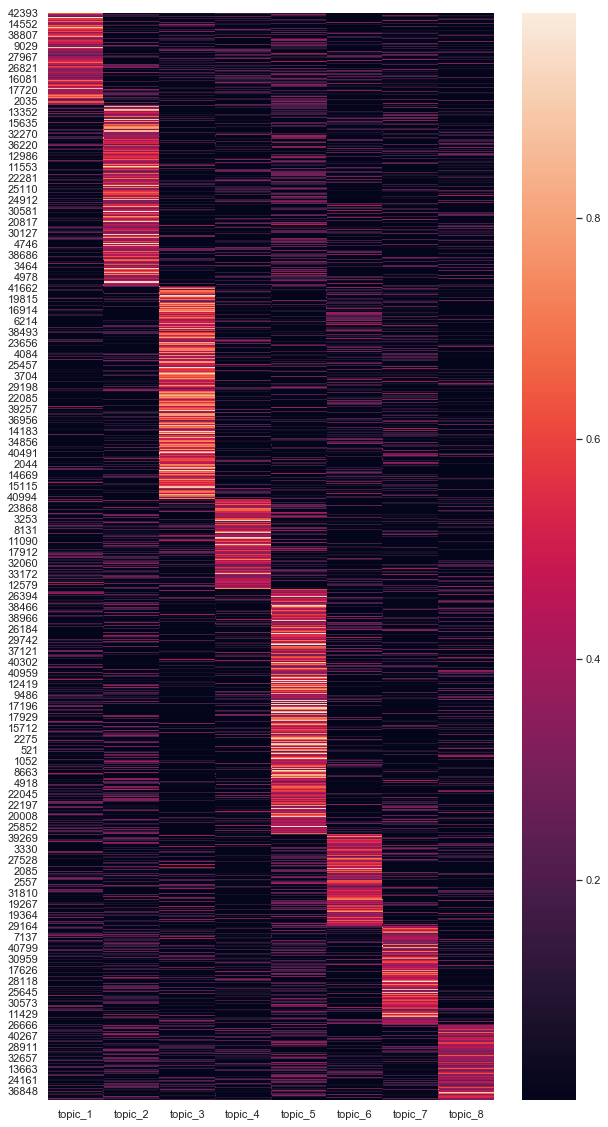

In [46]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(topic_prob_df.loc[topic_prob_df.idxmax(axis=1).sort_values().index])

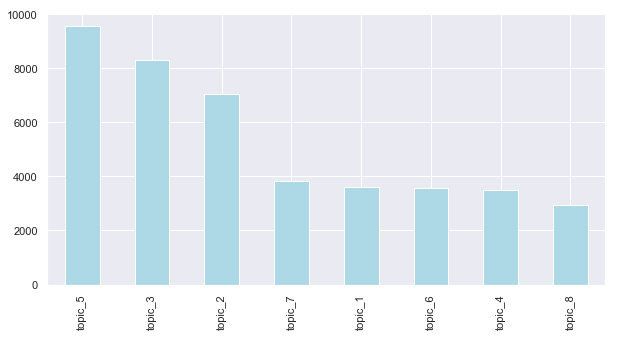

In [47]:
sns.set(rc={'figure.figsize':(10,5)})
topic_prob_df.idxmax(axis=1).value_counts().sort_values(ascending=False).plot.bar(color='lightblue')

In [48]:
topics = lda_model.show_topics(formatted=False)

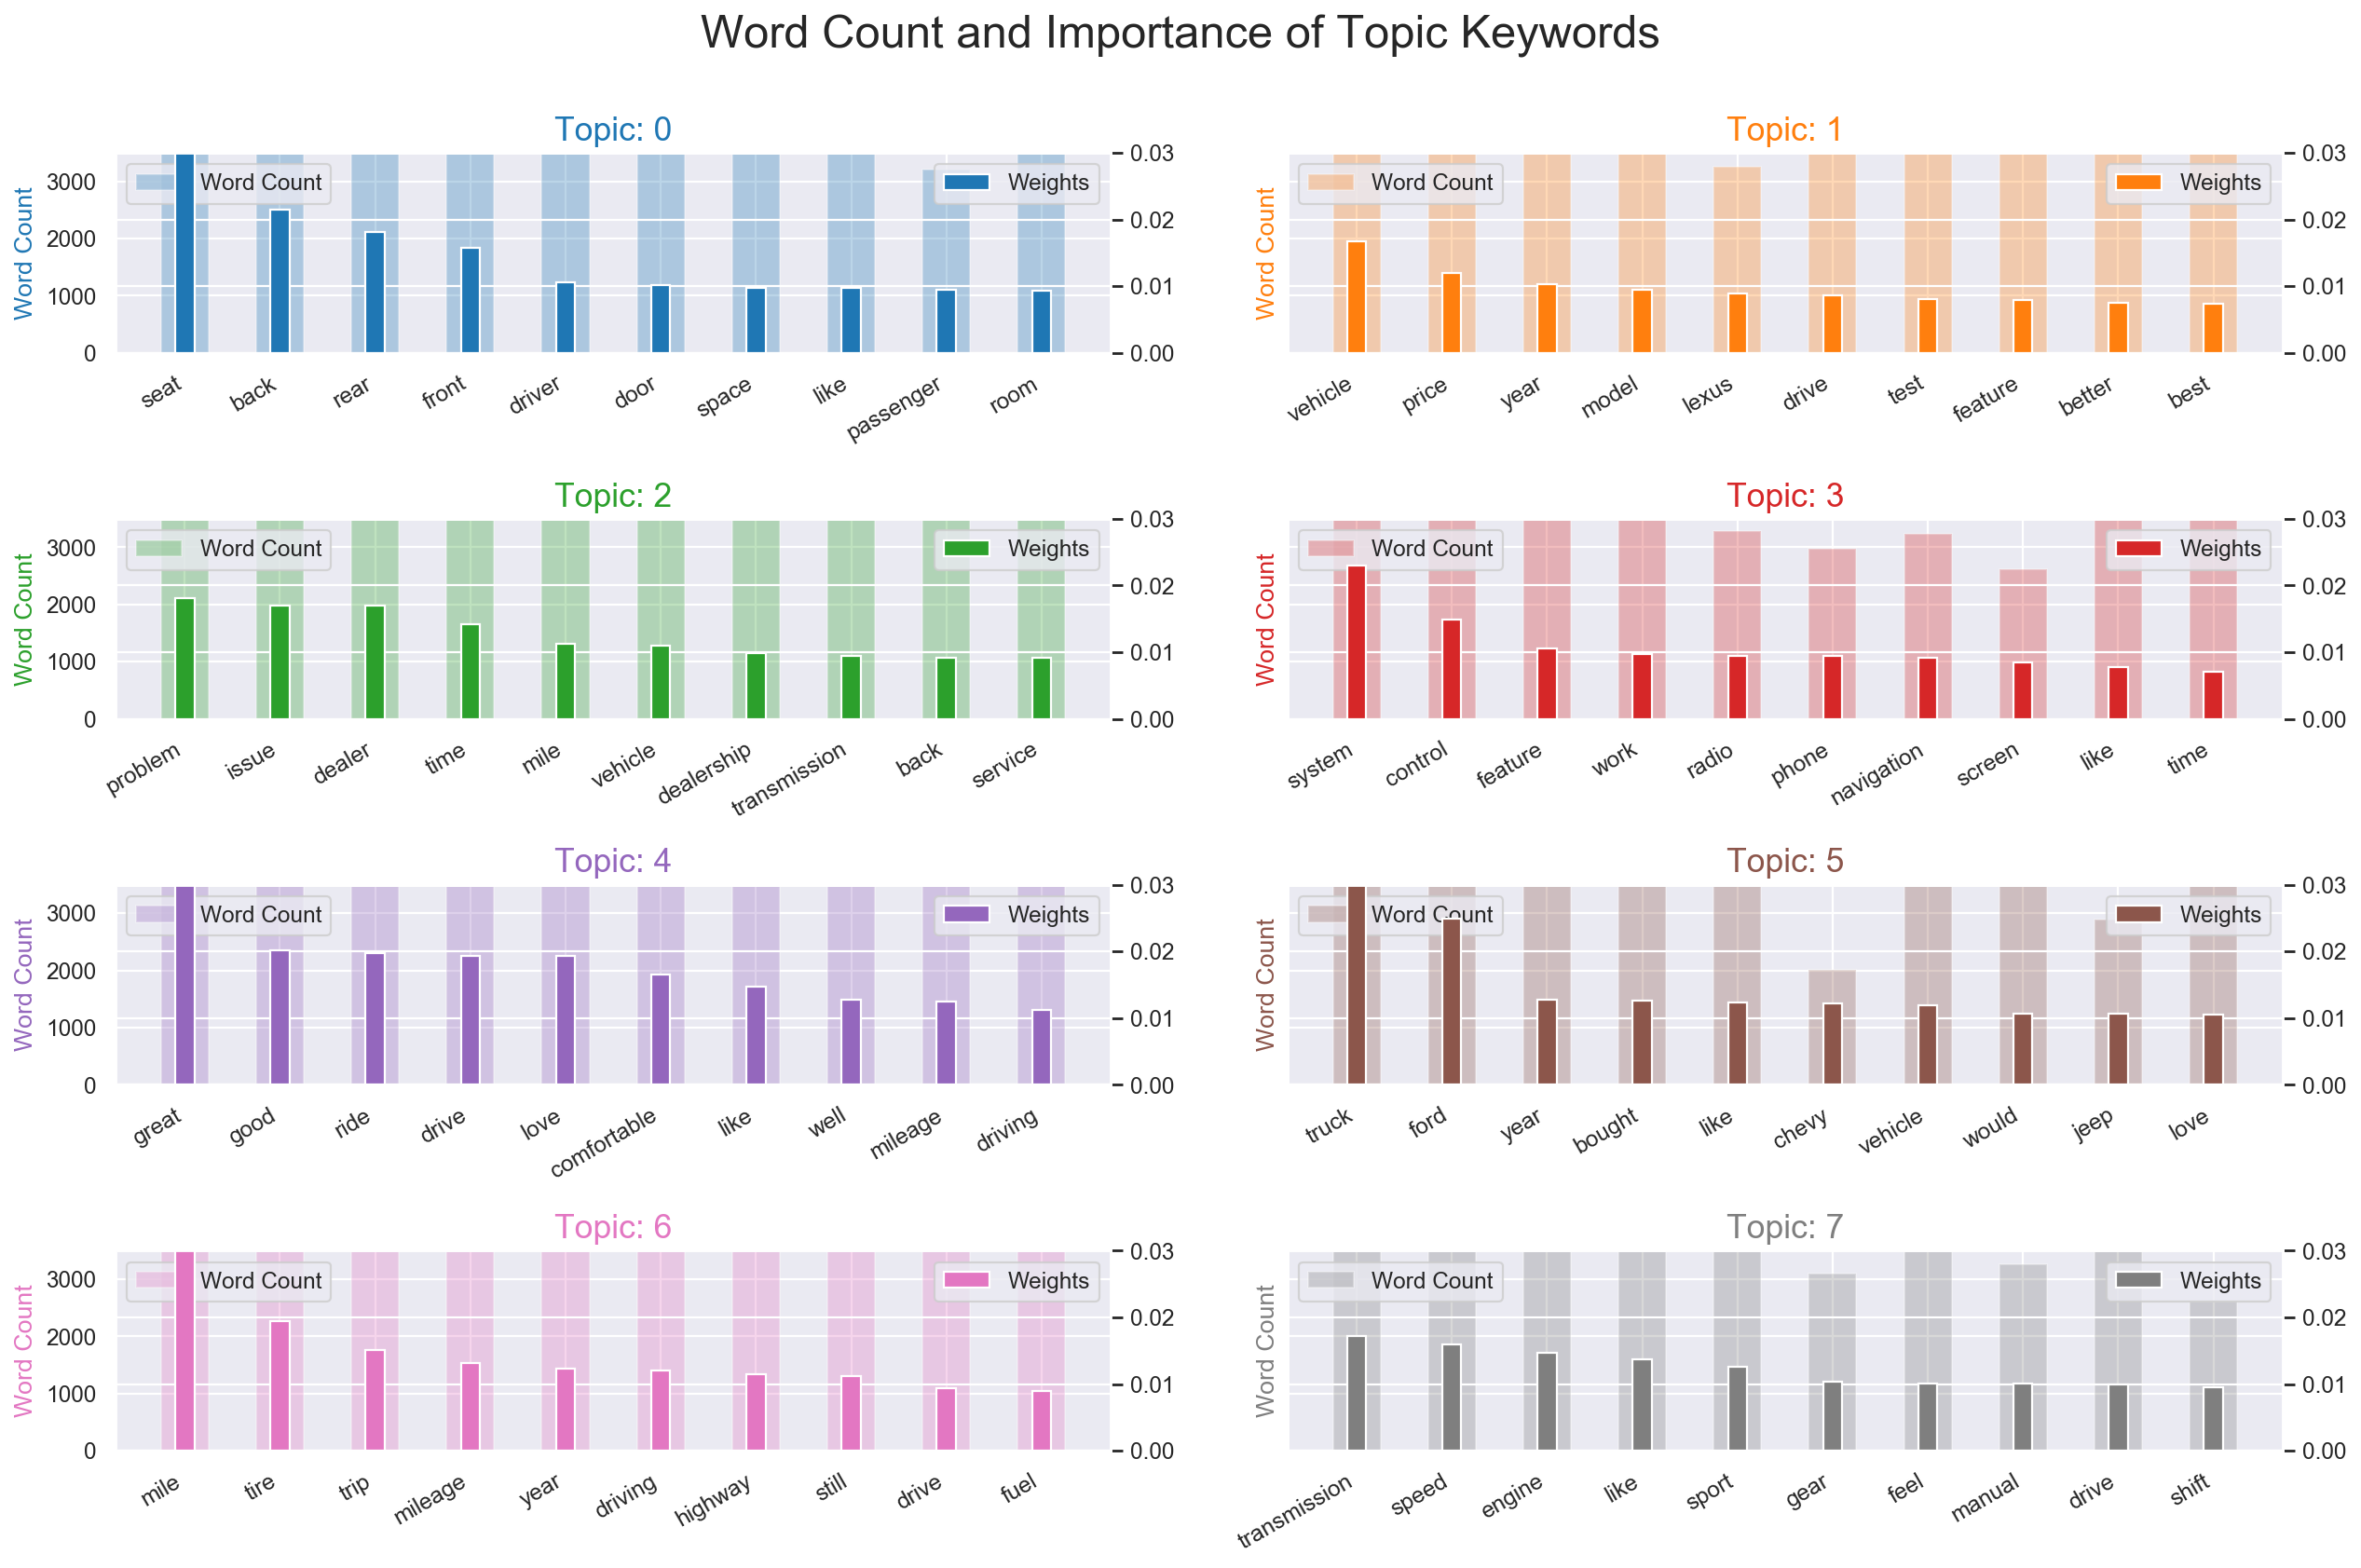

In [49]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


In [51]:
car_df_final.head()

,vehicle,review,rating,text_length,topic_num,topicprob,keywords,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,2011 Volkswagen Eos Convertible Lux SULEV 2dr ...,bought used love decade owned mercedes reminis...,5.0,31,4,0.5476,"great,good,ride,drive,love,comfortable,like,we...",0.003924,0.149058,0.075317,0.003913,0.548045,0.003913,0.003912,0.211918
1,2014 Volkswagen Eos Convertible Executive 2dr ...,beautiful understated done lack character hold...,4.0,40,7,0.3024,"transmission,speed,engine,like,sport,gear,feel...",0.003054,0.112374,0.003053,0.286241,0.284854,0.003054,0.003052,0.304318
2,2014 Volkswagen Eos Convertible Executive 2dr ...,purchased executive loving worried head room p...,4.0,17,4,0.8095,"great,good,ride,drive,love,comfortable,like,we...",0.006952,0.007019,0.006961,0.006946,0.808170,0.006953,0.150037,0.006960
3,2012 Volkswagen Eos Convertible Lux SULEV 2dr ...,sport period wife life style michlelins hold t...,5.0,72,7,0.3627,"transmission,speed,engine,like,sport,gear,feel...",0.355180,0.001715,0.070728,0.001715,0.001715,0.041462,0.163596,0.363889
4,2012 Volkswagen Eos Convertible Lux SULEV 2dr ...,bought november looking sharp convertible fron...,4.0,160,0,0.3071,"seat,back,rear,front,driver,door,space,like,pa...",0.307219,0.127407,0.117600,0.127863,0.275972,0.000778,0.042383,0.000778


In [ ]:
topics = ['Comfort','Price','Reliability','Technology','Car Handling','Trucks','Fuel Efficiency','Horsepower']

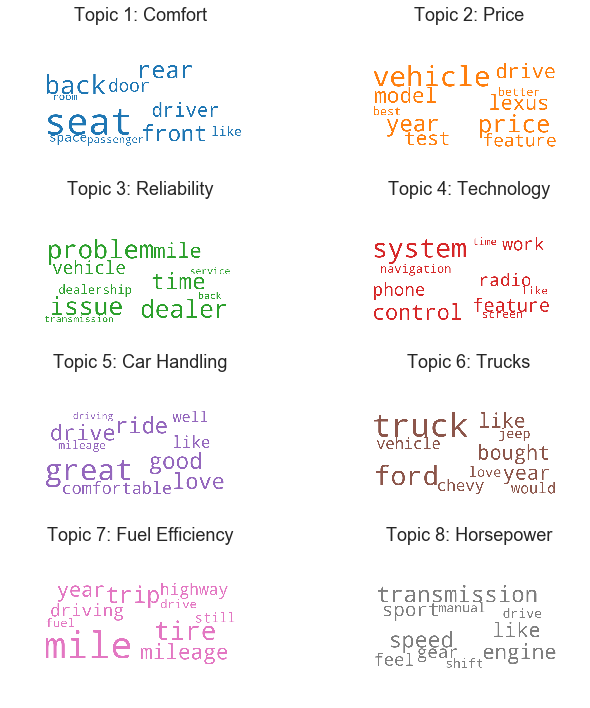

In [177]:
#  Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from PIL import Image
from os import path
import os

stop = set(stopwords.words('english'));

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
carmask = np.array(Image.open(path.join(d, "car.png")))

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  mask = carmask,
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
topics_name = ['Topic 1: Comfort','Topic 2: Price','Topic 3: Reliability','Topic 4: Technology','Topic 5: Car Handling','Topic 6: Trucks','Topic 7: Fuel Efficiency','Topic 8: Horsepower']

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topics_name[i], fontsize=18)
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
fig.savefig('wordcloud1.svg', format='svg', dpi=1200)

In [54]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.056*"seat" + 0.021*"back" + 0.018*"rear" + 0.016*"front" + 0.011*"driver" + 0.010*"door" + 0.010*"space" + 0.010*"like" + 0.009*"passenger" + 0.009*"room"
Topic: 1 Word: 0.017*"vehicle" + 0.012*"price" + 0.010*"year" + 0.009*"model" + 0.009*"lexus" + 0.009*"drive" + 0.008*"test" + 0.008*"feature" + 0.007*"better" + 0.007*"best"
Topic: 2 Word: 0.018*"problem" + 0.017*"issue" + 0.017*"dealer" + 0.014*"time" + 0.011*"mile" + 0.011*"vehicle" + 0.010*"dealership" + 0.009*"transmission" + 0.009*"back" + 0.009*"service"
Topic: 3 Word: 0.023*"system" + 0.015*"control" + 0.011*"feature" + 0.010*"work" + 0.009*"radio" + 0.009*"phone" + 0.009*"navigation" + 0.008*"screen" + 0.008*"like" + 0.007*"time"
Topic: 4 Word: 0.039*"great" + 0.020*"good" + 0.020*"ride" + 0.019*"drive" + 0.019*"love" + 0.017*"comfortable" + 0.015*"like" + 0.013*"well" + 0.012*"mileage" + 0.011*"driving"
Topic: 5 Word: 0.038*"truck" + 0.025*"ford" + 0.013*"year" + 0.013*"bought" + 0.012*"like" + 0.012*"chevy

# Using our LDA model to recommend cars on unseen documents.

In [55]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [56]:
unseen_document = 'fuel efficient '

bow_vector = dictionary.doc2bow(preprocess(unseen_document))
sorted(lda_model[bow_vector], key=lambda x:x[1],reverse=True)[0][0]

6

In [98]:
get_top_cars(car_df_final,0,10)

,vehicle,review,rating,text_length,topic_num,topicprob,keywords,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
15315,2012 Hyundai Santa Fe SUV Limited 4dr SUV (3.5...,santa cute especially comfortable come seating...,4.0,42,0,0.9796,"seat,back,rear,front,driver,door,space,like,pa...",0.979619,0.002916,0.002909,0.002912,0.002914,0.002909,0.002909,0.002912
30471,2015 Ford Edge SUV SEL 4dr SUV (2.0L 4cyl Turb...,edge great vehicle except plastic base front s...,4.0,24,0,0.9650,"seat,back,rear,front,driver,door,space,like,pa...",0.964951,0.005006,0.005005,0.005005,0.005018,0.005004,0.005006,0.005004
11685,2013 MINI Cooper Hatchback 2dr Hatchback (1.6L...,unfortunately automatic wife primary driver tr...,4.0,19,0,0.9562,"seat,back,rear,front,driver,door,space,like,pa...",0.956183,0.006257,0.006252,0.006259,0.006265,0.006254,0.006258,0.006271
8323,2014 Mazda 3 Sedan i SV 4dr Sedan (2.0L 4cyl 6M),either older carry older people around difficu...,4.0,18,0,0.9539,"seat,back,rear,front,driver,door,space,like,pa...",0.953868,0.006588,0.006596,0.006589,0.006585,0.006603,0.006588,0.006584
30633,2012 Ford Flex Wagon SEL 4dr Wagon (3.5L 6cyl 6A),perfect family ground like minivan interior sp...,5.0,18,0,0.9539,"seat,back,rear,front,driver,door,space,like,pa...",0.953864,0.006589,0.006591,0.006590,0.006586,0.006598,0.006593,0.006590
25374,2018 Acura MDX SUV SH-AWD w/Advance and Entert...,short person seat enough offer comfort accesso...,5.0,18,0,0.9539,"seat,back,rear,front,driver,door,space,like,pa...",0.953843,0.006584,0.006581,0.006590,0.006584,0.006582,0.006580,0.006655
2662,2011 GMC Sierra 1500 Extended Cab SLT 4dr Exte...,shorter stretch console high slide across fron...,4.0,17,0,0.9514,"seat,back,rear,front,driver,door,space,like,pa...",0.951368,0.006946,0.006947,0.006948,0.006948,0.006946,0.006948,0.006949
6178,2015 Mercedes-Benz CLS-Class Sedan CLS 400 4dr...,great negative back seat little hard adult bac...,5.0,16,0,0.9484,"seat,back,rear,front,driver,door,space,like,pa...",0.948412,0.007356,0.007408,0.007356,0.007375,0.007367,0.007370,0.007356
18772,2015 Toyota Camry Sedan LE 4dr Sedan (2.5L 4cy...,front seat poorly constructed enough cushion s...,4.0,16,0,0.9480,"seat,back,rear,front,driver,door,space,like,pa...",0.948447,0.007360,0.007361,0.007358,0.007386,0.007361,0.007359,0.007369
42131,2016 Chevrolet Equinox SUV LT 4dr SUV AWD (2.4...,small butt found riding outer rise bucket fron...,2.0,15,0,0.9453,"seat,back,rear,front,driver,door,space,like,pa...",0.945294,0.007816,0.007816,0.007814,0.007816,0.007815,0.007816,0.007813


### TSNE Visualizations 

In [57]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.manifold import TSNE
output_notebook()


Loading BokehJS ...

Using Seaborn Scatter plot

In [58]:
hm = np.array([[y for (x,y) in lda_model[bow_corpus[i]]] for i in range(len(bow_corpus))])

In [92]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 20-D -> 2-D
tsne_lda = tsne_model.fit_transform(hm)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 42394 samples in 0.019s...
[t-SNE] Computed neighbors for 42394 samples in 3.923s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42394
[t-SNE] Computed conditional probabilities for sample 2000 / 42394
[t-SNE] Computed conditional probabilities for sample 3000 / 42394
[t-SNE] Computed conditional probabilities for sample 4000 / 42394
[t-SNE] Computed conditional probabilities for sample 5000 / 42394
[t-SNE] Computed conditional probabilities for sample 6000 / 42394
[t-SNE] Computed conditional probabilities for sample 7000 / 42394
[t-SNE] Computed conditional probabilities for sample 8000 / 42394
[t-SNE] Computed conditional probabilities for sample 9000 / 42394
[t-SNE] Computed conditional probabilities for sample 10000 / 42394
[t-SNE] Computed conditional probabilities for sample 11000 / 42394
[t-SNE] Computed conditional probabilities for sample 12000 / 42394
[t-SNE] Computed conditional probabilities for sam

In [110]:
tsne_lda_df = pd.DataFrame(tsne_lda, columns =['x','y'])

In [124]:
tsne_lda_df['topics'] = hm.argmax(axis=1)

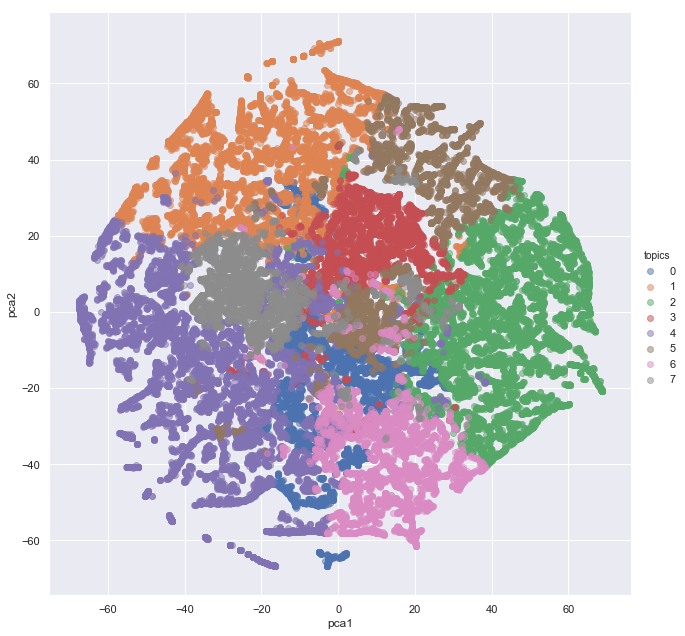

In [176]:
sns.lmplot(x='x',y='y',data = tsne_lda_df, hue ='topics',fit_reg=False,legend=True,height=9, scatter_kws={'alpha':0.5})
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.savefig("TSNE.svg")

Using Bokeh

In [59]:
tsne = TSNE(random_state=2017, perplexity=30)
tsne_embedding = tsne.fit_transform(hm)
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_embedding['hue'] = hm.argmax(axis=1)

In [63]:
tsne_embedding.hue.unique()

array([4, 7, 0, 2, 5, 1, 6, 3])

In [75]:
colors = [all_palettes['Set1'][8][i] for i in tsne_embedding.hue]

In [84]:
source = ColumnDataSource(
        data=dict(
            x = tsne_embedding.x,
            y = tsne_embedding.y,
            colors = [all_palettes['Set1'][9][i] for i in tsne_embedding.hue],
            alpha = [0.9] * tsne_embedding.shape[0],
            size = [7] * tsne_embedding.shape[0],
            label= ['Topic 1','Topic 2','Topic 3', 'Topic 4','Topic 5','Topic 6' , 'Topic 7', 'Topic 8']
        )
    )
tools_tsne = ['pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Cars')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', legend='label',  
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")






GlyphRenderer(id='1495', ...)

In [85]:
layout = column(plot_tsne)
show(layout)

## 'Recommending System' based on Text  #1

In [86]:
unseen_document = 'a big car that has a lot of space'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
topic_num = sorted(lda_model[bow_vector], key=lambda x:x[1],reverse=True)[0][0]
print(topic_num)

0


In [135]:
topic_num

0

In [151]:
list(get_top_cars_filter(car_df_final,topic_num,10,'suv').vehicle)

['2012 Hyundai Santa Fe SUV Limited 4dr SUV (3.5L 6cyl 6A)',
 '2015 Ford Edge SUV SEL 4dr SUV (2.0L 4cyl Turbo 6A)',
 '2018 Acura MDX SUV SH-AWD w/Advance and Entertainment Packages 4dr SUV AWD (3.5L 6cyl 9A)',
 '2016 Chevrolet Equinox SUV LT 4dr SUV AWD (2.4L 4cyl 6A)',
 '2016 Honda HR-V SUV EX 4dr SUV (1.8L 4cyl 6M)',
 '2014 Acura MDX SUV SH-AWD 4dr SUV AWD (3.5L 6cyl 6A)',
 '2017 Acura RDX SUV 4dr SUV (3.5L 6cyl 6A)',
 '2016 Honda CR-V SUV EX-L 4dr SUV AWD (2.4L 4cyl CVT)',
 '2012 Chevrolet Equinox SUV LT 4dr SUV w/2LT (2.4L 4cyl 6A)',
 '2017 Ford Explorer SUV 4dr SUV AWD (3.5L 6cyl 6A)']

## Adding car types to the dataframe

In [129]:
car_df_final.loc[(car_df_final.vehicle.str.contains('SUV'),'type')] = 'suv'
car_df_final.loc[(car_df_final.vehicle.str.contains('Convertible'),'type')] = 'convertible'
car_df_final.loc[(car_df_final.vehicle.str.contains('Sedan'),'type')] = 'sedan';
car_df_final.loc[(car_df_final.vehicle.str.contains('Hatchback'),'type')] = 'hatchback';
car_df_final.loc[(car_df_final.vehicle.str.contains('SportWagen'),'type')] = 'hatchback';
car_df_final.loc[(car_df_final.vehicle.str.contains('Wagon'),'type')] = 'hatchback';
car_df_final.loc[(car_df_final.vehicle.str.contains('Van'),'type')] = 'van'
car_df_final.loc[(car_df_final.vehicle.str.contains('Minivan'),'type')] = 'van'
car_df_final.loc[(car_df_final.vehicle.str.contains('Coupe'),'type')] = 'coupe'
car_df_final.loc[(car_df_final.vehicle.str.contains('GMC'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Honda Ridgeline'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Chevrolet Silverado'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Toyota Tacoma'),'type')] = 'truck' 
car_df_final.loc[(car_df_final.vehicle.str.contains('Toyota Tundra'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Ford F-150'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains(' F-450'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains(' Ford F-250'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Ford F-350'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Ford Ranger'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Nissan Titan'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Nissan Frontier '),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Ram'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Suzuki Equator'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Chevrolet Avalanche'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Chevrolet Colorado'),'type')] = 'truck'
car_df_final.loc[(car_df_final.vehicle.str.contains('Chevrolet Black'),'type')] = 'truck'

### Recommending based given a car type

In [ ]:
car_df_final[car_df_final.vehicle == '2017 Acura RDX SUV 4dr SUV (3.5L 6cyl 6A)']['topic_num']

In [144]:
get_top_cars_filter(car_df_final,0,10,'suv')

,vehicle,review,rating,text_length,topic_num,topicprob,keywords,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,type
15315,2012 Hyundai Santa Fe SUV Limited 4dr SUV (3.5...,santa cute especially comfortable come seating...,4.0,42,0,0.9796,"seat,back,rear,front,driver,door,space,like,pa...",0.979619,0.002916,0.002909,0.002912,0.002914,0.002909,0.002909,0.002912,suv
30471,2015 Ford Edge SUV SEL 4dr SUV (2.0L 4cyl Turb...,edge great vehicle except plastic base front s...,4.0,24,0,0.9650,"seat,back,rear,front,driver,door,space,like,pa...",0.964951,0.005006,0.005005,0.005005,0.005018,0.005004,0.005006,0.005004,suv
25374,2018 Acura MDX SUV SH-AWD w/Advance and Entert...,short person seat enough offer comfort accesso...,5.0,18,0,0.9539,"seat,back,rear,front,driver,door,space,like,pa...",0.953843,0.006584,0.006581,0.006590,0.006584,0.006582,0.006580,0.006655,suv
42131,2016 Chevrolet Equinox SUV LT 4dr SUV AWD (2.4...,small butt found riding outer rise bucket fron...,2.0,15,0,0.9453,"seat,back,rear,front,driver,door,space,like,pa...",0.945294,0.007816,0.007816,0.007814,0.007816,0.007815,0.007816,0.007813,suv
8679,2016 Honda HR-V SUV EX 4dr SUV (1.8L 4cyl 6M),great realize driving seat cause back pain sea...,1.0,15,0,0.9452,"seat,back,rear,front,driver,door,space,like,pa...",0.945230,0.007819,0.007821,0.007823,0.007834,0.007823,0.007822,0.007827,suv
25185,2014 Acura MDX SUV SH-AWD 4dr SUV AWD (3.5L 6c...,acura handle curve well grip road roomy back s...,5.0,34,0,0.9420,"seat,back,rear,front,driver,door,space,like,pa...",0.942001,0.036547,0.003574,0.003575,0.003579,0.003573,0.003573,0.003577,suv
24633,2017 Acura RDX SUV 4dr SUV (3.5L 6cyl 6A),space back seat wish would real leather seat l...,5.0,14,0,0.9416,"seat,back,rear,front,driver,door,space,like,pa...",0.941615,0.008341,0.008337,0.008339,0.008346,0.008343,0.008337,0.008342,suv
9557,2016 Honda CR-V SUV EX-L 4dr SUV AWD (2.4L 4cy...,front seat great seat rear room plus door open...,5.0,13,0,0.9375,"seat,back,rear,front,driver,door,space,like,pa...",0.937455,0.008937,0.008930,0.008933,0.008948,0.008932,0.008935,0.008930,suv
42068,2012 Chevrolet Equinox SUV LT 4dr SUV w/2LT (2...,although small large capacity passenger cargo ...,5.0,13,0,0.9374,"seat,back,rear,front,driver,door,space,like,pa...",0.937446,0.008935,0.008934,0.008936,0.008945,0.008932,0.008934,0.008937,suv
31954,2017 Ford Explorer SUV 4dr SUV AWD (3.5L 6cyl 6A),nicest small enough drive alone feel like driv...,5.0,16,0,0.9294,"seat,back,rear,front,driver,door,space,like,pa...",0.920499,0.007370,0.007360,0.007359,0.035311,0.007366,0.007366,0.007368,suv


In [198]:
#given a word in text

unseen_document = 'I need a sedan that has a lot of space'
tmp2 = preprocess(unseen_document)
automobile_types =['truck','suv','convertible','sedan','hatchback','van','coupe']
word_tmp = []
for word in tmp2:
    if word in automobile_types:
        word_tmp.append(word)


In [207]:
#Writing a function to determine which function to use based on the input user text:
if len(word_tmp) == 0:
    new = get_top_cars(car_df_final,topic_num,10).vehicle.values
else:   
    new = get_top_cars_filter(car_df_final,topic_num,10,word_tmp[0]).vehicle.values